# Modelling Section

**Welcome to modelling section!**

This is the second notebook for **the scraped Apartment dataset**. Here, we will **create and evaluate** some **models** from the data that have been cleaned before to **predict the price** and **find out** the things that have **the most important variable** to the model

**1. What models will be tested ?**
- LightGBM
- Catboost
- Blended

**2. What parameters to evaluate them?**

a. *MSE ( Mean Squared Error )*
 

Average of the square of the difference between actual and estimated values

b. *RMSE ( Root Mean Squared Error )*

Basically, this value got from square root of average error. It can a be parameter to compare the models with each other and **I would use** this to **identify** if the model is more **over/underfitting** than the others.

c. *R2 ( R-Squared )*

The proportion of the variance in the dependent variable that is predictable from the independent variable

d. *MAE ( Mean Absolute Error )*

Average of the absolute values of the difference between actual and estimated values

------------------------------------------------------------------------

We will only evaluate the models with RMSE and check the accuracy using R2 score in the last section

***After testing the models one by one in baseline mode, I'm gonna do hyperparameter tuning and would be compare it with the baseline model***

*N.B: I did the hyperparameter tuning for CatBoost model in another notebook but the result is not satisfying*

**3. Results**:
- Annual price( label, we will inverse after the process finished ), Area, bathroom, longitude, and latitude columns are **transformed** into **log form**
- Only four features have a correlation score of more than 0.5 with the annual rent price. Those are *Washing Machine*, *Room*, *Area*, and *Bathroom*
- The table below is the result of cross-validation with k=5
- 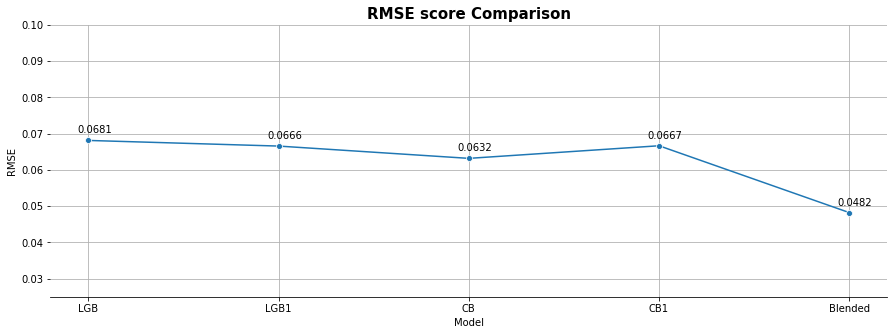
- The chosen model is Blended version : **20%** LightGBM baseline model, **10%** LightGBM hyperparameter tuning, **40%** Catboost baseline model, and **30%** Catboost parameters from another resource 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.pyplot import rcParams
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns',100)
rcParams['figure.figsize'] = (15,5)
rcParams['axes.grid'] = True
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
plt.rc('axes',axisbelow=True)

In [6]:
df = pd.read_csv('D:/Data/apartment/fr/cleaned_1.csv').drop(['full_apartment_name','link','unit_name','region'],axis=1)
df=df[df.annual_price<6e8]
df.sample(2)

,room,bathroom,Furnished,Area,annual_price,atm,basketball_court,cable_tv,function_room,grocery_store,gym,internet,jogging_track,swimming_pool,tennis_court,laundry,restaurant,security,playground,ac,access_card,water_heater,washing_machine,kitchen,dining_set,fridge,bed,tv,Latitude,Longitude
7028,3 BR,2,Fully Furnished,99.0,92000000.0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,-6.180500,106.8284
2920,2 BR,2,Fully Furnished,146.0,406601700.0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,-6.261493,106.8106


In [7]:
df.shape

(7289, 30)

**Interesting! From 7452 to 7289 raws. We only remove 2% of data**

In [8]:
df.replace({'room':{'BR':'','Studio':0},
           },regex=True,inplace=True)

In [9]:
df_new = pd.concat([df,pd.get_dummies(df['Furnished'])],axis=1).drop('Furnished',axis=1)
df_new['room'] = df_new.room.astype(int)
df_new.head()

,room,bathroom,Area,annual_price,atm,basketball_court,cable_tv,function_room,grocery_store,gym,internet,jogging_track,swimming_pool,tennis_court,laundry,restaurant,security,playground,ac,access_card,water_heater,washing_machine,kitchen,dining_set,fridge,bed,tv,Latitude,Longitude,Fully Furnished,Non Furnished,Semi Furnished
0,1,1,42.0,90000000.0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,-6.180500,106.8284,1,0,0
1,1,1,35.0,44000000.0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,-6.167400,106.7637,0,1,0
2,2,1,54.0,70000000.0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,-6.225014,106.9004,1,0,0
3,0,1,24.0,25000000.0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,-6.167400,106.7637,1,0,0
4,0,1,26.0,24000000.0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,-6.167400,106.7637,0,0,1


# Understand the data

### Normality

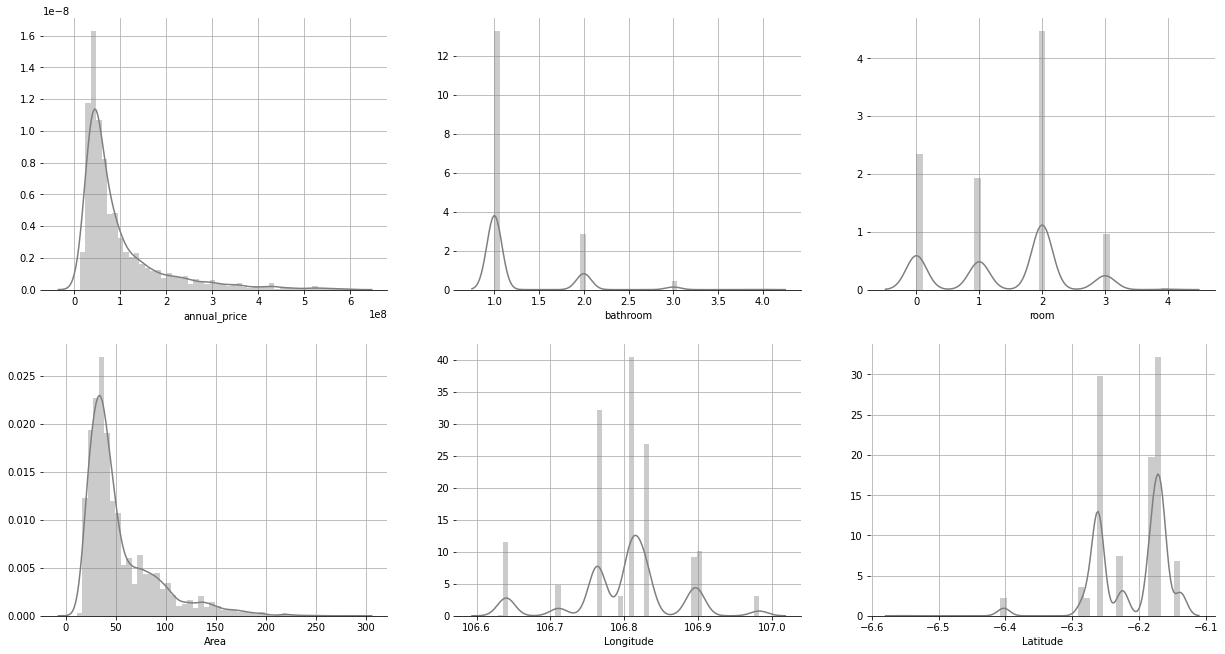

In [10]:
plt.figure(figsize=(21,11))
num = ['annual_price','bathroom','room','Area','Longitude','Latitude']
for i in range(len(df_new[num].columns)):
    plt.subplot(2,len(df_new[num].columns)/2,i+1)
    sns.distplot(df_new[num[i]],color='tab:grey')
    plt.ylabel('') 

Let's transform some of them for better distribution

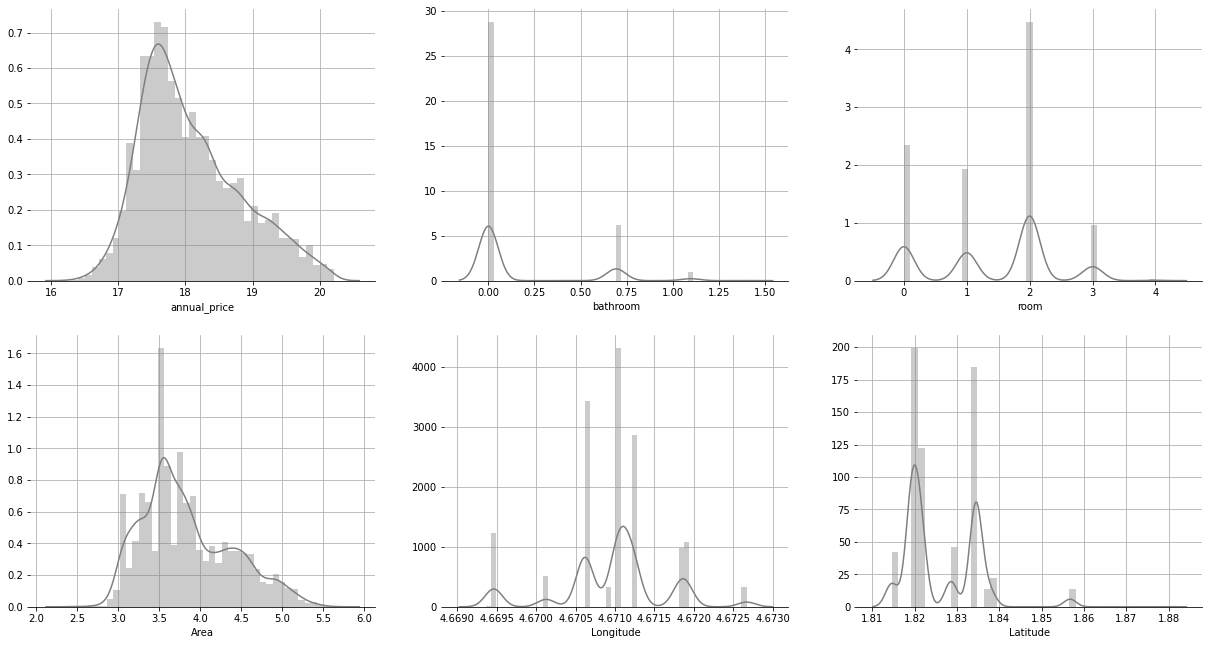

In [11]:
plt.figure(figsize=(21,11))

df2 = df_new.copy()
df2['annual_price']= np.log(df2.annual_price)
df2['Area'] = np.log(df2.Area)
df2['bathroom'] = np.log(df2.bathroom)
df2['Longitude'] = np.log(df2.Longitude)
df2['Latitude'] = np.log(np.abs(df2.Latitude))

for i in range(len(df2[num].columns)):
    plt.subplot(2,len(df2[num].columns)/2,i+1)
    sns.distplot(df2[num[i]],color='tab:grey')
    plt.ylabel('') 

In [12]:
df2[num].skew()

annual_price    0.658434
bathroom        1.709253
room           -0.207452
Area            0.622508
Longitude      -0.365813
Latitude        1.039023
dtype: float64

Looks better

## Correlation

We will not remove any features that we have since we have done with that before and , In my opinion, the remaining variables are logically important in the real-world. Thus, we will only look correlation of each feature with the dependent variable

In [13]:
corr = df2.corr().drop(columns='annual_price',errors='ignore')

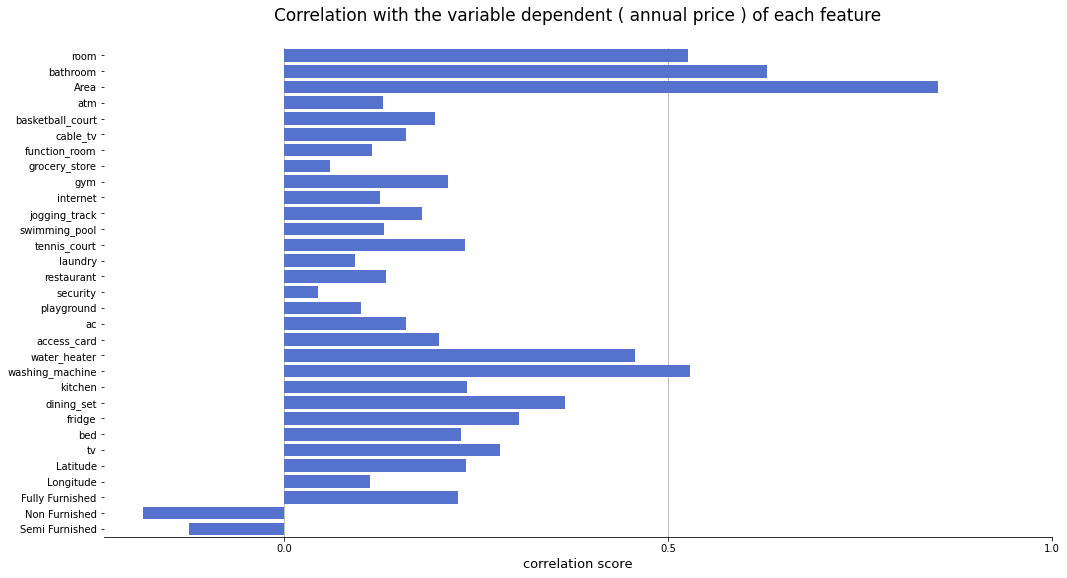

In [14]:
plt.figure(figsize=(17,9))
sns.barplot(y=corr.loc['annual_price'].index,x=corr.loc['annual_price'],color='royalblue')
plt.title('Correlation with the variable dependent ( annual price ) of each feature\n',size=17)
plt.xlabel('correlation score',size=13)
plt.xticks([0,5e-1,10e-1])
plt.show()

There are **four features** that have correlation score more than **0.5** with ***the annual rent price***. Those are *Washing Machine*, *Room*, *Area*, and *Bathroom*

# Split and Create a function for evaluating the models

Splitting the data into train and test set. We will put 20% of that into test set and the rest into training set

In [15]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [16]:
X = df2.drop('annual_price',axis=1)
y = df2.annual_price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [17]:
def scores(model, name):
    test_val = y_test.values.tolist()
    prediction = model.predict(X_test)    
        
    sns.scatterplot(test_val, prediction)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    score = pd.Series({'Model':name,
              'RMSE_train': mean_squared_error(y_train, model.predict(X_train)),
              'RMSE_test': mean_squared_error(y_test, model.predict(X_test)),
              'R2_train': r2_score(y_train, model.predict(X_train)),
              'R2_test': r2_score(y_test, model.predict(X_test))
             })
    return score


# Modelling

## Set up the model

## LightGBM

LightGBM, which stands for **Light Gradient Boosting Machine**, is originally developed by Microsoft. This model is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient. However, it will not yield an outcome which can be interpreted as clear as Linear Regression. It doesn't have any explicit coefficient which can further be tested with t-test and calculate it's p-value

the other advantages are:
- Capable of handling large-scale data		
- Lower memory usage
- Support of parallel and GPU learning	
- Better accuracy
- Faster training speed and higher efficiency	

### Baseline model ( Version 1 )

In [18]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

Model         LGB_ver1
RMSE_train    0.050393
RMSE_test      0.06047
R2_train      0.908765
R2_test       0.885349
dtype: object


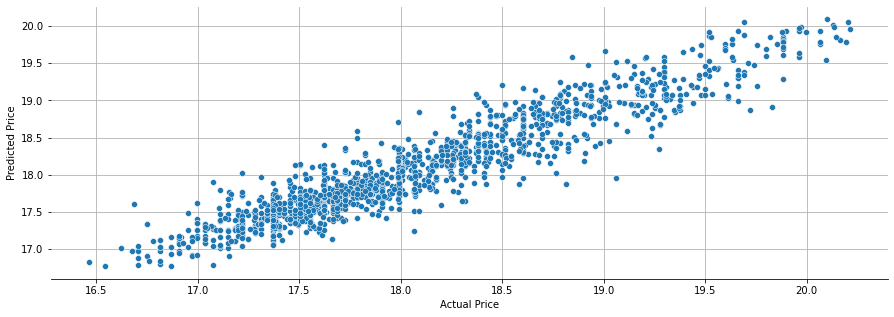

In [19]:
lgb1_df = scores(lgb,'LGB_ver1')
print(lgb1_df)
score = pd.Series()
score = pd.concat([score,lgb1_df],axis=1)

### Hyperparameter tuning ( Version 2 )

In [20]:
gparams1 = {'learning_rate':[x for x in np.arange(0.01,0.1,0.02)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': np.arange(0.1, 1.1),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14],
           'booster':['gbtree','gblinear','dart']
           }

In [21]:
kf = KFold(5,shuffle=True,random_state=42)

In [22]:
lgb1 = LGBMRegressor()
rsc1 = RandomizedSearchCV(lgb1,gparams1,cv=kf.get_n_splits(X,y),verbose=1,n_jobs=-1,random_state=100,scoring='neg_mean_squared_error')
rsc1.fit(X_train,y_train)

print(rsc1.score(X_test,y_test))
print(rsc1.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
-0.06261729556445614
{'scale_pos_weight': 14, 'reg_alpha': 0.5499999999999999, 'n_estimators': 86, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.08999999999999998, 'gamma': 0.1, 'booster': 'gbtree'}


In [23]:
lgb1 = LGBMRegressor(**rsc1.best_params_)
lgb1.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster


LGBMRegressor(booster='gbtree', gamma=0.1, learning_rate=0.08999999999999998,
              max_depth=7, min_child_weight=6, n_estimators=86,
              reg_alpha=0.5499999999999999, scale_pos_weight=14)

Model         LGB_ver2
RMSE_train    0.056508
RMSE_test     0.062617
R2_train      0.897692
R2_test       0.881277
dtype: object


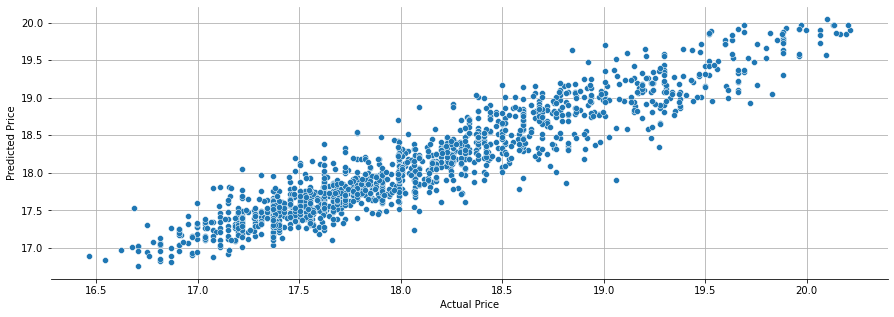

In [24]:
lgb2_df = scores(lgb1,'LGB_ver2')
print(lgb2_df)
score = pd.concat([score, lgb2_df],axis=1)

## Catboost

CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers. Some of the advantages:
- Fast and scalable GPU version			
- Fast prediction
- Categorical features support			
- Improved accuracy
- Great quality without parameter tuning


### Baseline model ( Version 1 )

Using default parameters

In [25]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor()
cb.fit(X_train, y_train,verbose=False)

Model         CatBoost_ver1
RMSE_train         0.041857
RMSE_test          0.054748
R2_train           0.924217
R2_test            0.896197
dtype: object


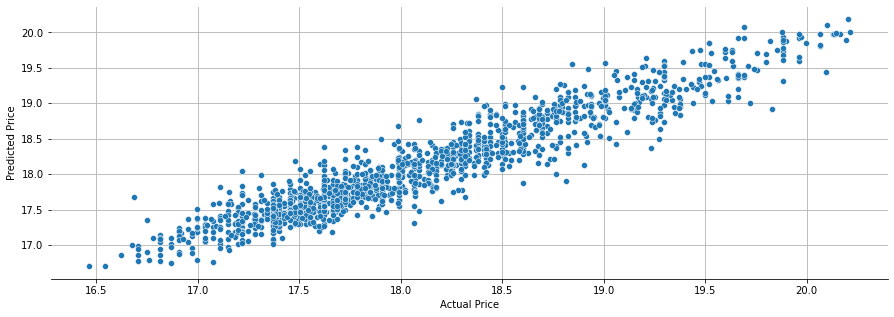

In [26]:
cb1_df = scores(cb, 'CatBoost_ver1')
print(cb1_df)
score = pd.concat([score, cb1_df],axis=1)

### ( Version 2 )

I tuned in another notebook

In [27]:
cb1 = CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.006, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=500)
cb1.fit(X_train, y_train)

0:	learn: 0.7398661	total: 4.13ms	remaining: 16.5s
500:	learn: 0.2905832	total: 2.04s	remaining: 14.3s
1000:	learn: 0.2651728	total: 4.2s	remaining: 12.6s
1500:	learn: 0.2540762	total: 6.74s	remaining: 11.2s
2000:	learn: 0.2465322	total: 9.36s	remaining: 9.35s
2500:	learn: 0.2399791	total: 11.5s	remaining: 6.89s
3000:	learn: 0.2347659	total: 13.7s	remaining: 4.55s
3500:	learn: 0.2305493	total: 16s	remaining: 2.27s
3999:	learn: 0.2269260	total: 18.5s	remaining: 0us


Model         CatBoost_ver2
RMSE_train         0.051495
RMSE_test           0.05774
R2_train           0.906768
R2_test            0.890524
dtype: object


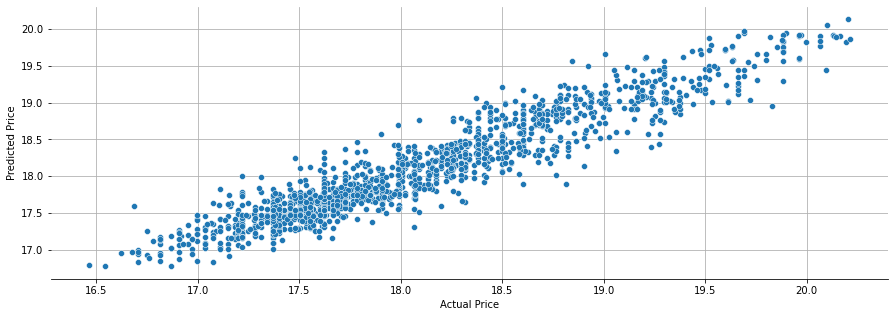

In [28]:
cb2_df = scores(cb1, 'CatBoost_ver2')
print(cb2_df)
score = pd.concat([score, cb2_df],axis=1)

In [29]:
score.columns = score.iloc[0]
score

Model,NaN,LGB_ver1,LGB_ver2,CatBoost_ver1,CatBoost_ver2
Model,NaN,LGB_ver1,LGB_ver2,CatBoost_ver1,CatBoost_ver2
RMSE_train,NaN,0.050393,0.056508,0.041857,0.051495
RMSE_test,NaN,0.06047,0.062617,0.054748,0.05774
R2_train,NaN,0.908765,0.897692,0.924217,0.906768
R2_test,NaN,0.885349,0.881277,0.896197,0.890524


# Cross Validation

In [30]:
models = []

models.append(('LGB', LGBMRegressor()))
models.append(('LGB1', LGBMRegressor(**rsc1.best_params_)))
models.append(('CB', CatBoostRegressor(verbose=1000)))
models.append(('CB1', CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.006, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=1000)))

# evaluate each model in turning kfold results
results_boxplot = []
names = []
results_mean = []
results_std = []
p,t = X_train.values, y_train.values.ravel()
for name, model in models:
    cv_results = (-cross_val_score(model, p,t, cv=5,scoring='neg_mean_squared_error',n_jobs=-1))
    results_boxplot.append(cv_results)
    results_mean.append(cv_results.mean())
    results_std.append(cv_results.std())
    names.append(name)
pd.DataFrame({"Algorithm":names,
                                "RMSE Mean":results_mean,
                                "RMSE Std":results_std})

,Algorithm,RMSE Mean,RMSE Std
0,LGB,0.068145,0.002758
1,LGB1,0.070730,0.002528
2,CB,0.063200,0.002210
3,CB1,0.065843,0.002451


# Blended Version

Developed by myself by blending the XGBoost, LightGBM, and CatBoost models. 
Since the single model will be prone to overfit, this model will predict the result of each model that has been trained to get more robust results. Thus, the blending is a type of stacking where the meta-model is fit using predictions on a holdout validation dataset instead of out-of-fold predictions

The compositions are:
\ 

*How did I get the percentage?* 

Practically, by trial and error. However, I also considered the  RMSE which I got from the cross-validation process.

In [31]:
def blended_predictions(X):
    return (
            (0.2* lgb.predict(X)) + \
            (0.1* lgb1.predict(X)) + \
            (0.4* cb.predict(X))+\
            (0.3* cb1.predict(X))
           )

In [32]:
print(mean_squared_error(y_train, blended_predictions(X_train)))
print(r2_score(y_train, blended_predictions(X_train)))

0.046653840670014386
0.9155335513690879


In [33]:
print(mean_squared_error(y_test, blended_predictions(X_test)))
print(r2_score(y_test, blended_predictions(X_test)))

0.056378929483234246
0.8931048888362534


In [34]:
model = []
for i,j in models:
    model.append(i)
model.append('Blended')

In [35]:
result = pd.DataFrame([model,results_mean+[mean_squared_error(y_train, blended_predictions(X_train))]]).T
result.columns = ['Model','RMSE']

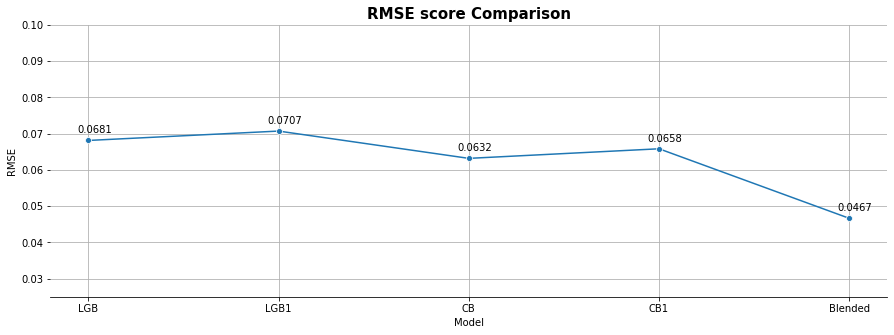

In [36]:
sns.lineplot('Model','RMSE',data=result,marker='o')
plt.ylim(0.025,0.1)
plt.title('RMSE score Comparison',size=15,fontweight=550)
for a,b in zip(range(len(result.Model)),result.RMSE):
    plt.text(a-0.06,b+0.002,str(round(b,4)))
plt.show()

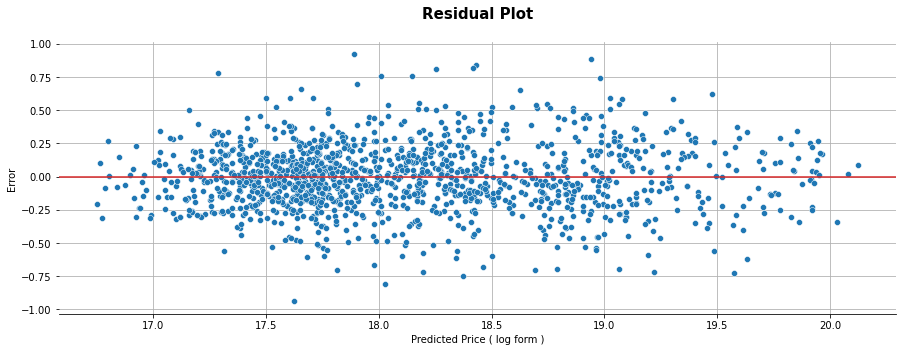

In [37]:
res = y_test - blended_predictions(X_test)
plt.axhline(color='tab:red')
sns.scatterplot(blended_predictions(X_test), res)
plt.ylabel('Error')
plt.title('Residual Plot\n',size=15,fontweight=550)
plt.xlabel('Predicted Price ( log form )')
plt.show()

## Price in Validation Set

In [38]:
dp = pd.concat([np.exp(y_train),pd.Series(np.exp(blended_predictions(X_train)),index=y_train.index)],axis=1)
dp.columns =['real_price','predicted_price']
dp['error'] = dp.real_price - dp.predicted_price
dp['abs_error'] = np.abs(dp.real_price - dp.predicted_price)

In [39]:
dp.describe()

,real_price,predicted_price,error,abs_error
count,5.831000e+03,5.831000e+03,5.831000e+03,5.831000e+03
mean,9.704206e+07,9.338780e+07,3.654255e+06,1.727887e+07
std,9.299741e+07,8.237574e+07,3.103980e+07,2.604255e+07
min,1.200000e+07,1.812883e+07,-1.689989e+08,4.295514e+03
25%,4.100000e+07,4.188097e+07,-6.995581e+06,3.343519e+06
50%,6.000000e+07,5.924820e+07,-3.034810e+05,7.845093e+06
75%,1.130000e+08,1.130078e+08,9.061383e+06,1.895091e+07
max,5.994000e+08,5.538320e+08,3.689949e+08,3.689949e+08


# Checking what the result is if we remove top 20 error (Just for validation)

In [40]:
np.log(dp.abs_error.sort_values(ascending=False))

4788    19.726293
1801    19.602448
1821    19.581916
2466    19.392661
1599    19.355791
          ...    
4742     8.605303
4821     8.605303
4963     8.605303
4999     8.605303
4153     8.365326
Name: abs_error, Length: 5831, dtype: float64

In [41]:
X_train_new = X_train.drop(index=dp.sort_values('abs_error',ascending=False).head(20).index)
y_train_new = y_train.drop(index=dp.sort_values('abs_error',ascending=False).head(20).index)

In [42]:
lgb1_new = LGBMRegressor().fit(X_train_new,y_train_new)
lgb2_new = LGBMRegressor(**rsc1.best_params_).fit(X_train_new,y_train_new)
cb1_new = CatBoostRegressor(verbose=False).fit(X_train_new,y_train_new)
cb2_new = CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.006, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=False).fit(X_train_new,y_train_new)

In [43]:
def blended_predictionss(X):
    return (
            0.2*lgb1_new.predict(X) + \
            (0.1 * lgb2_new.predict(X)) + \
            (0.4 * cb1_new.predict(X))+\
            (0.3 * cb2_new.predict(X))
            )

In [44]:
print(mean_squared_error(y_train_new, blended_predictionss(X_train_new)))
print(r2_score(y_train_new, blended_predictionss(X_train_new)))

0.044576910349699794
0.9181963415657634


In [45]:
print(mean_squared_error(y_test, blended_predictionss(X_test)))
print(r2_score(y_test, blended_predictionss(X_test)))

0.05587623483175753
0.8940580037879483


# Create prediction Interval

In [46]:
y_preds = np.zeros((X_test.shape[0], 4))
# insert quantiles that we want to check
quantiles = [.01, .05, .95, .99]

# the process is similar to how we do our usual train test splitting
test_val = y_test.to_numpy().reshape(len(y_test), 1)

# however, there will be 4 generated outputs for each input, each one of them corresponds to the quantiles that we specify

for i in range(len(quantiles)):
    lgb = LGBMRegressor(objective = 'quantile', alpha=quantiles[i])
    lgb_q = lgb.fit(X_train, y_train)
    lgb1 = LGBMRegressor(**rsc1.best_params_ ,objective = 'quantile', alpha=quantiles[i])
    lgb1_q = lgb1.fit(X_train, y_train)
    cb  = CatBoostRegressor(objective='Quantile:alpha={}'.format(quantiles[i]),verbose=False)
    cb1  = CatBoostRegressor(
                       learning_rate=0.006, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=False,objective='Quantile:alpha={}'.format(quantiles[i]))
    cb_q = cb.fit(X_train,y_train)
    cb1_q = cb1.fit(X_train, y_train)
    y_preds[:,i] = 0.2*lgb_q.predict(X_test)+\
                         0.1*lgb1_q.predict(X_test)+\
                         0.4*cb_q.predict(X_test)+\
                         0.3*cb1_q.predict(X_test)


In [47]:
test_val = np.exp(test_val)
y_preds1 = np.exp(y_preds)

In [48]:
ActualPrice = list()
I_1 = list()
I_99 = list()
is_in_1_99 = list()
I_5 = list()
I_95 = list()
is_in_5_95 = list()

for i in range(len(test_val)):
    actual_price = test_val[i][0]
    ActualPrice.append(actual_price)
    pred_1_prcnt = y_preds1[i][0]
    I_1.append(pred_1_prcnt)
    pred_5_prcnt = y_preds1[i][1]
    I_5.append(pred_5_prcnt)
    pred_95_prcnt = y_preds1[i][2]
    I_95.append(pred_95_prcnt)
    pred_99_prcnt = y_preds1[i][3]
    I_99.append(pred_99_prcnt)
    
    if actual_price < pred_99_prcnt and actual_price > pred_1_prcnt:
        is_in_1_99.append(1)
    else:
        is_in_1_99.append(0)
    
    if actual_price < pred_95_prcnt and actual_price > pred_5_prcnt:
        is_in_5_95.append(1)
    else:
        is_in_5_95.append(0)
        

quantile_pred = pd.DataFrame(zip(ActualPrice, I_1, I_99, is_in_1_99, I_5, I_95, is_in_5_95))
quantile_pred = quantile_pred.rename({0:'Actual Annual Rent Price', 1:'Quantile 0.01', 2:'Quantile 0.99',
                                     3:'Between 1% and 99%', 4:'Quantile 0.05', 5:'Quantile 0.95',
                                     6:'Between 5% and 95%'}, axis = 'columns')
quantile_pred.describe()

,Actual Annual Rent Price,Quantile 0.01,Quantile 0.99,Between 1% and 99%,Quantile 0.05,Quantile 0.95,Between 5% and 95%
count,1.458000e+03,1.458000e+03,1.458000e+03,1458.000000,1.458000e+03,1.458000e+03,1458.000000
mean,9.666224e+07,4.275031e+07,1.710327e+08,0.961591,5.994554e+07,1.420252e+08,0.884774
std,9.092363e+07,2.713695e+07,1.255278e+08,0.192247,4.850268e+07,1.160561e+08,0.319404
min,1.410000e+07,1.315583e+07,4.269026e+07,0.000000,1.299461e+07,3.039154e+07,0.000000
25%,4.200000e+07,2.669004e+07,7.857735e+07,1.000000,3.165597e+07,6.016486e+07,1.000000
50%,6.300000e+07,3.448014e+07,1.156145e+08,1.000000,4.141657e+07,9.058770e+07,1.000000
75%,1.130000e+08,5.027981e+07,2.287277e+08,1.000000,7.028549e+07,1.881381e+08,1.000000
max,5.994000e+08,3.557551e+08,5.999554e+08,1.000000,3.745046e+08,5.877848e+08,1.000000


## Interval 5-95

In [49]:
interval = quantile_pred['Quantile 0.95'] - quantile_pred['Quantile 0.05']
sort_ind = np.argsort(interval)
y_true_all = quantile_pred['Actual Annual Rent Price'][sort_ind]

In [50]:
mean = ( quantile_pred['Quantile 0.95'] +  quantile_pred['Quantile 0.05']) / 2

# Center such that the mean of the prediction interval is at 0.0
upper =  quantile_pred['Quantile 0.95']
lower =  quantile_pred['Quantile 0.05']
y_true_all -= mean
upper -= mean
lower -= mean

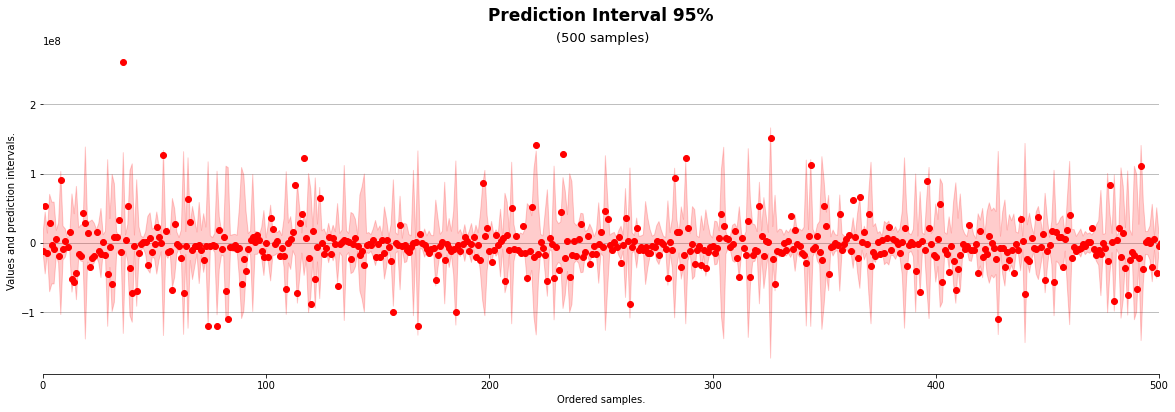

In [51]:
plt.figure(figsize=(20,6))
plt.plot(y_true_all, "ro")
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.title('Prediction Interval 95%\n',size=17,fontweight=550)
plt.text(230,2.9e8,'(500 samples)',fontsize=13)
plt.xlim([0, 500])
plt.grid(axis='x')
plt.show()

## Interval 1 and 99

In [52]:
interval1 = quantile_pred['Quantile 0.99'] - quantile_pred['Quantile 0.01']
sort_ind1 = np.argsort(interval1)
y_true_all1 = quantile_pred['Actual Annual Rent Price'][sort_ind1]

In [53]:
mean1 = ( quantile_pred['Quantile 0.99'] +  quantile_pred['Quantile 0.01']) / 2

# Center such that the mean of the prediction interval is at 0.0
upper1 =  quantile_pred['Quantile 0.99']
lower1 =  quantile_pred['Quantile 0.01']
y_true_all1 -= mean1
upper1 -= mean1
lower1 -= mean1

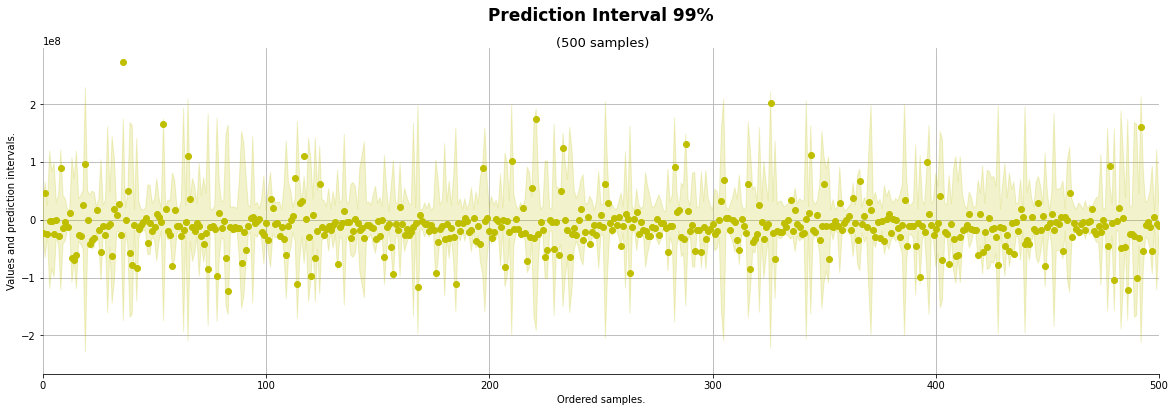

In [54]:
plt.figure(figsize=(20,6))
plt.plot(y_true_all1, "yo")
plt.fill_between(
    np.arange(len(upper1)), lower1, upper1, alpha=0.2, color="y",
    label="Pred. interval")
plt.title('Prediction Interval 99%\n',size=17,fontweight=550)
plt.text(230,3e8,'(500 samples)',fontsize=13)
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 500])
plt.show()

## Feature Importance

In [55]:
lgb = LGBMRegressor()
lgb1 = LGBMRegressor(**rsc1.best_params_)
cb  = CatBoostRegressor(verbose=False)
cb1  = CatBoostRegressor(
                       learning_rate=0.006, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=False)

In [56]:
lgb.fit(X_train,y_train)
lgb1.fit(X_train,y_train)
cb.fit(X_train,y_train)
cb1.fit(X_train,y_train)

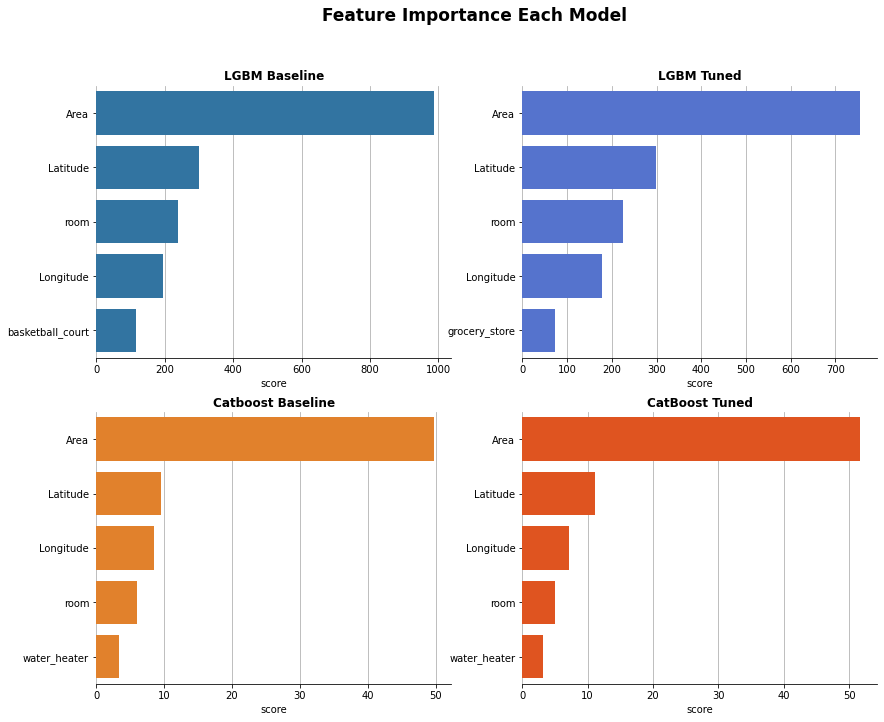

In [90]:
fig, ax = plt.subplots(2,2,figsize=(14,11))

sns.barplot('weight','feature',data=pd.DataFrame({'feature':X_train.columns,'weight':lgb.feature_importances_}).sort_values('weight',ascending=False).head(),color='tab:blue',ax=ax[0,0])
sns.barplot('weight','feature',data=pd.DataFrame({'feature':X_train.columns,'weight':lgb1.feature_importances_}).sort_values('weight',ascending=False).head(),color='royalblue',ax=ax[0,1])
sns.barplot('weight','feature',data=pd.DataFrame({'feature':X_train.columns,'weight':cb.feature_importances_}).sort_values('weight',ascending=False).head(),color='tab:orange',ax=ax[1,0])
sns.barplot('weight','feature',data=pd.DataFrame({'feature':X_train.columns,'weight':cb1.feature_importances_}).sort_values('weight',ascending=False).head(),color='orangered',ax=ax[1,1])
ax[0,0].set_xlabel('score')
ax[0,1].set_xlabel('score')
ax[1,0].set_xlabel('score')
ax[1,1].set_xlabel('score')
ax[0,0].set_ylabel('')
ax[1,0].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,1].set_ylabel('')

ax[0,0].set_title('LGBM Baseline',fontweight=550)
ax[1,0].set_title('Catboost Baseline',fontweight=550)
ax[1,1].set_title('CatBoost Tuned',fontweight=550)
ax[0,1].set_title('LGBM Tuned',fontweight=550)

fig.suptitle('Feature Importance Each Model',size=17,fontweight=550)
plt.show()